In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json
/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json


**Resources we used**

https://www.kaggle.com/code/abdulbasitniazi/word2vec-glove-a-beginner-s-guide
https://www.kaggle.com/code/prashantpathak244/sarcasm-detection-81
https://www.kaggle.com/code/madz2000/sarcasm-detection-with-glove-word2vec-83-accuracy/notebook

**Let's first import the librairies we are going to use**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn import decomposition
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
from sklearn.metrics import precision_recall_fscore_support as score
import re,string,unicodedata
from keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from string import punctuation
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf
import missingno as msno

**Loading Data**

In [3]:
df = pd.read_json("../input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json", lines=True)
del df['article_link'] 
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


In [4]:
df.shape

(26709, 2)

In [5]:
df2 = pd.read_json('/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json' , lines = True)
del df2['article_link'] 
df2.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [6]:
df2.shape

(28619, 2)

**Seems like the 2 data sets we are given are different which will let us multiple way to test our models (we can use any of them and split it into train/test OR use one for train and the other for test)**

**Visualization**

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

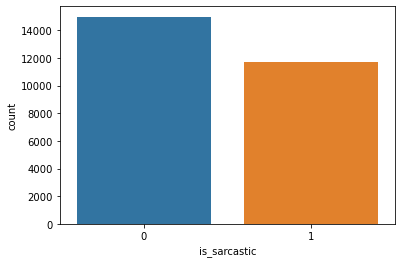

In [7]:
sns.countplot(df.is_sarcastic)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='is_sarcastic', ylabel='count'>

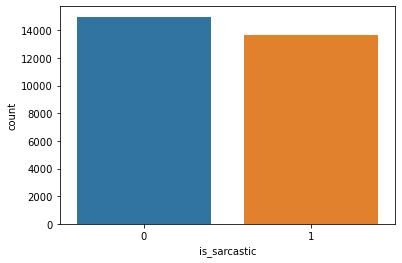

In [8]:
sns.countplot(df2.is_sarcastic)

**The data is balanced**

**WORDCLOUD FOR TEXT THAT IS NOT SARCASTIC (LABEL - 0)**

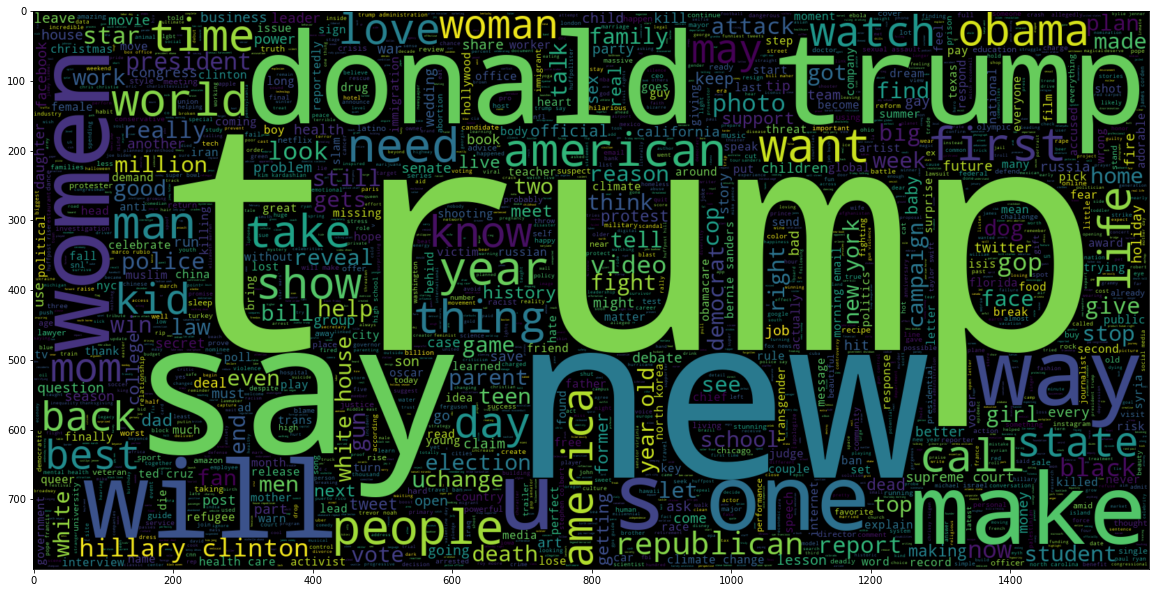

In [9]:
plt.figure(figsize = (20,20)) # Text that is Not Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 0].headline))
plt.imshow(wc , interpolation = 'bilinear')

**WORDCLOUD FOR SARCASTIC TEXT (LABEL - 1)**

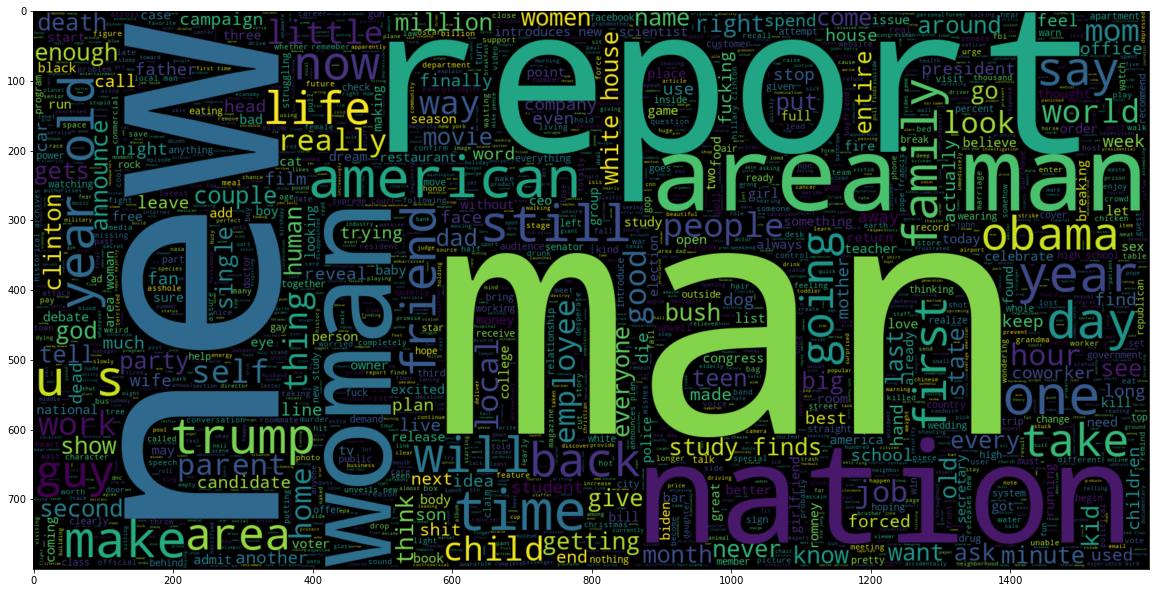

In [10]:
plt.figure(figsize = (20,20)) # Text that is Sarcastic
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc , interpolation = 'bilinear')

**Number of characters in texts**

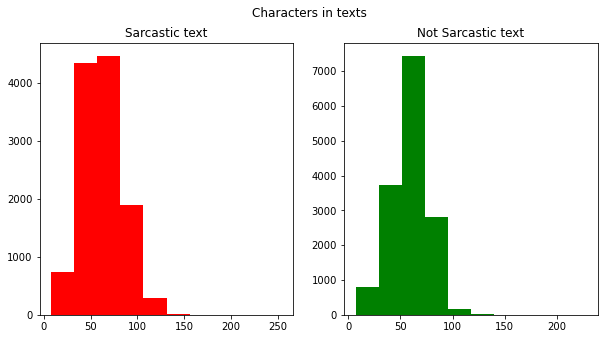

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Characters in texts')
plt.show()

**Number of words in each text**

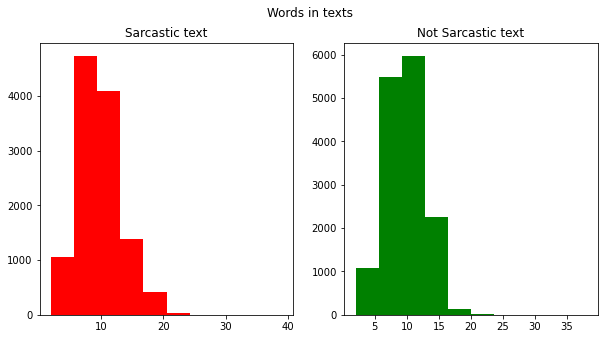

In [12]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Words in texts')
plt.show()

**Average word length in a text**

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average word length in each text')

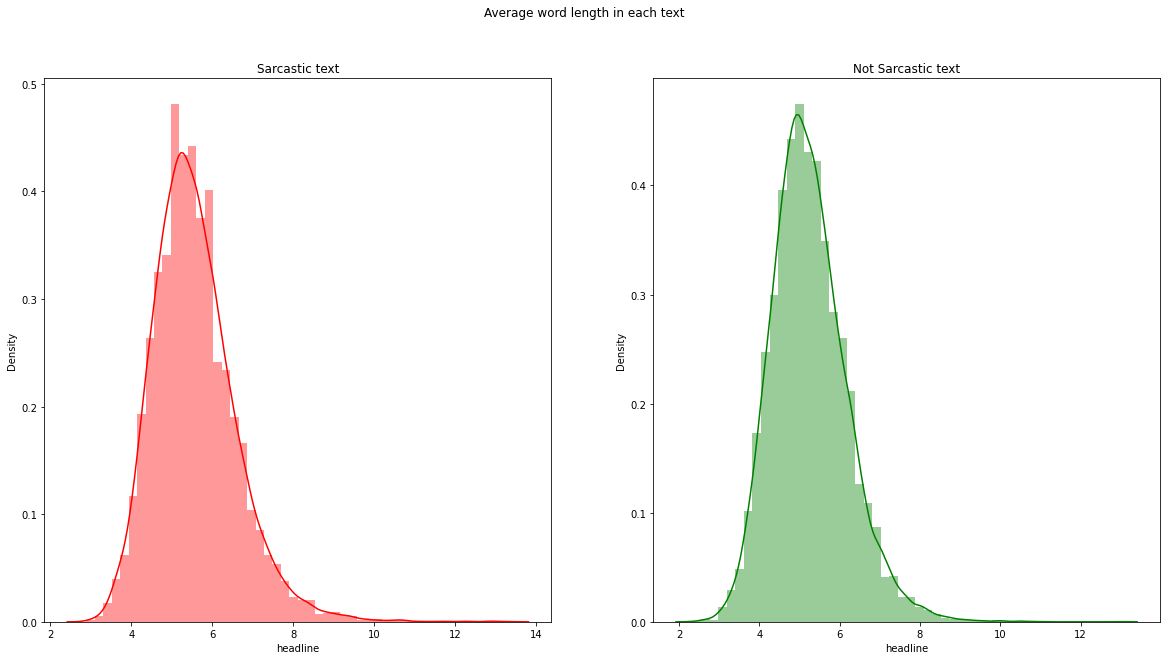

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title('Sarcastic text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x : [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title('Not Sarcastic text')
fig.suptitle('Average word length in each text')

**Pre-processing**

In [14]:
df.isna().sum()

headline        0
is_sarcastic    0
dtype: int64

In [15]:
df2.isna().sum()

is_sarcastic    0
headline        0
dtype: int64

**There isn't any missing values**

**topwords are the English words which does not add much meaning to a sentence**

In [16]:
#stopword removal 
stop = set(stopwords.words('english'))
p = list(string.punctuation)
stop.update(p)

**Basic Data Cleaning**

In [17]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_url(text):
    return re.sub('http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if (i.strip().lower() not in stop):
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [18]:
df['headline']=df['headline'].apply(denoise_text)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [19]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret 'black ...,0
1,'roseanne' revival catches thorny political mo...,0
2,mom starting fear son's web series closest thi...,1
3,"boehner wants wife listen, come alternative de...",1
4,j.k. rowling wishes snape happy birthday magic...,0


**We still have undesired punctuation like 'roseanne'**

In [20]:
def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

In [21]:
df['headline']=df['headline'].apply(remove_punctuation)

In [22]:
df.head()

,headline,is_sarcastic
0,former versace store clerk sues secret black c...,0
1,roseanne revival catches thorny political mood...,0
2,mom starting fear sons web series closest thin...,1
3,boehner wants wife listen come alternative deb...,1
4,jk rowling wishes snape happy birthday magical...,0


In [23]:
df['headline'].iloc[45]

'christian bale visits sikh temple victims'

**It seems like we are done cleaning**

**We are going to use the first set (df) for the train/test split**

In [24]:
x_train, x_test, y_train, y_test = train_test_split(df.headline, df.is_sarcastic , test_size = 0.3 , random_state = 0) 

In [25]:
x_train.shape, x_test.shape

((18696,), (8013,))

**Let's start by testing some vectorizer and models**

**With CountVectorizer**

In [26]:
def algos_test_CountVectorizer(train_xs, test_xs, train_ys, test_ys):
    vectorizer = CountVectorizer()
    train_xs = vectorizer.fit_transform(train_xs)
    test_xs = vectorizer.transform(test_xs)

    algos = [
        LogisticRegression(),
        MultinomialNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        xgb.XGBClassifier()
    ]
    results = []
    for algo in algos:
        print(algo)
        %timeit -n 1 -r 1 algo.fit(train_xs, train_ys)
        pred_ys = algo.predict(test_xs)
        results.append(
            {
                "algo": algo,
                "accuracy": accuracy_score(test_ys, pred_ys),
                "precision": score(test_ys, pred_ys, average="macro")[0],
                "recall": score(test_ys, pred_ys, average="macro")[1],
                "f1": score(test_ys, pred_ys, average="macro")[2],
            }
        )
    return pd.DataFrame.from_records(results)

results_CountVectorizer = algos_test_CountVectorizer(x_train, x_test, y_train, y_test)
results_CountVectorizer

LogisticRegression()
931 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
MultinomialNB()
24.5 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
DecisionTreeClassifier()
8.45 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
RandomForestClassifier()
35.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
SVC()
1min 24s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None,

,algo,accuracy,precision,recall,f1
0,LogisticRegression(),0.794584,0.795300,0.785976,0.788773
1,MultinomialNB(),0.803819,0.802650,0.797662,0.799508
2,DecisionTreeClassifier(),0.729065,0.725334,0.722634,0.723647
3,"(DecisionTreeClassifier(max_features='auto', r...",0.752402,0.763294,0.735180,0.738286
4,SVC(),0.791089,0.803113,0.775958,0.780513
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.722326,0.756285,0.695473,0.693120


**With TfidVectorizer**

In [27]:
def algos_test_TfidVectorizer(train_xs, test_xs, train_ys, test_ys):
    vectorizer = TfidfVectorizer()
    train_xs = vectorizer.fit_transform(train_xs)
    test_xs = vectorizer.transform(test_xs)

    algos = [
        LogisticRegression(),
        MultinomialNB(),
        DecisionTreeClassifier(),
        RandomForestClassifier(),
        SVC(),
        xgb.XGBClassifier()
    ]
    results = []
    for algo in algos:
        print(algo)
        %timeit -n 1 -r 1 algo.fit(train_xs, train_ys)
        pred_ys = algo.predict(test_xs)
        results.append(
            {
                "algo": algo,
                "accuracy": accuracy_score(test_ys, pred_ys),
                "precision": score(test_ys, pred_ys, average="macro")[0],
                "recall": score(test_ys, pred_ys, average="macro")[1],
                "f1": score(test_ys, pred_ys, average="macro")[2],
            }
        )
    return pd.DataFrame.from_records(results)

results_TfidVectorizer = algos_test_TfidVectorizer(x_train, x_test, y_train, y_test)
results_TfidVectorizer

LogisticRegression()
1.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
MultinomialNB()
18.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
DecisionTreeClassifier()
11.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
RandomForestClassifier()
33.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
SVC()
1min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, 

,algo,accuracy,precision,recall,f1
0,LogisticRegression(),0.790715,0.794471,0.779658,0.783240
1,MultinomialNB(),0.792088,0.806503,0.776097,0.780818
2,DecisionTreeClassifier(),0.715462,0.711346,0.709001,0.709885
3,"(DecisionTreeClassifier(max_features='auto', r...",0.759266,0.764701,0.745228,0.748526
4,SVC(),0.796331,0.800844,0.785128,0.788904
5,"XGBClassifier(base_score=0.5, booster='gbtree'...",0.716461,0.749430,0.689298,0.686236


**It seems like there isn't much of a difference between CountVectorizer and TfidVectorizer, and we got 80/79% accuracy with MultinomialNB model and SVC**

**Next things to try : word embedding with Word2Vec and Glove (expected to get better results by capturing the context)**